Amplitude fourier transform

In [3]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
from scipy.interpolate import griddata
sys.path.append('/Users/jiarong/Google Drive/codes/jiarongw-postprocessing/functions')
# sys.path.append('/home/jiarong/research/postprocessing/functions/')
# os.chdir('/home/jiarong/research/windwave')
# os.chdir('./linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10')
from Amplitude import Amplitude
from fio import readin

Some figures:  
$\sigma = \frac{1}{k^2 \times BO}$   
$\omega^2 = gk(1+\frac{\sigma k^2}{\rho_w g})= gk(1+1/BO) = gk(1+1/3.45)$  
$\omega = 2.846$  
$c = \omega / k = 0.4532$  
Orbital velocity from gravity wave $Ux_{max} = \frac{ag}{\omega}k = (ak)g/\omega = (ak)*0.0176$  
The time period in the original code is computed by $\omega^2 = gk$, which is a significant deviation.

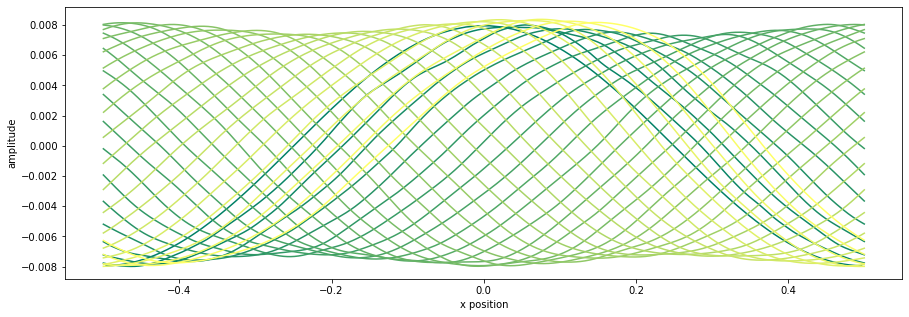

In [4]:
# It's the iterator's job to assemble the filename and read
def iter_onecase(postfix_index_set, tag_set, tag_common):
    '''
    postfix_index_set: list of numbers
        A list of corresponding indices used to distinguish the cases.
    tag_set: list of strings
        A list of tags that distinguish each case, can be different from the index set 
    
    '''

    # Instantiate amplitude as a list
    amplitude = []
    
    for i,(index,tag) in enumerate(zip(postfix_index_set, tag_set)):   
        # Use the enhanced read-in function   
        # Rewrite the line according to the file naming 
        # filename = 'filename_common' + '%g' %postfix_index + file_format
        filename = './eta' + '%g' %index
        # Rewrite this line according to the delimiter and the fields attributes
        eta = readin(filename, table_delimiter = ',')
        eta.rename(columns={'pos':'eta'}, inplace=True)
        # Instantiate a amplitude class member
        ampl = Amplitude(eta[['x', 'eta', 'f']])
        amplitude.append(ampl)
        ampl.plot_amplitude(ax, color_choice=plt.cm.get_cmap('summer')(color_idx[i]), label_choice=tag_common+tag)
        # A mark line on crest position if necessary
    #         crest = np.array(eta[eta['pos']==eta['pos'].max()].x)
    #         x_crest = np.average(crest)
    #         x = x_crest*np.ones(100)
    #         y = np.linspace(0, 0.02, 100, endpoint=True)
    #         plt.plot(x, y, color=plt.cm.get_cmap('summer')(color_idx[(i+1)//delta]))

    # def amplitude(eta):
    return amplitude
    
# In this case postfix_index and tag have the same content   
postfix_index = np.linspace(0, 1, 33)
tag = np.char.mod('%d', postfix_index)

fig = plt.figure(figsize = (15, 5))
ax = fig.gca()
color_idx = np.linspace(0, 1, len(postfix_index))

amplitude = iter_onecase(postfix_index_set=postfix_index, tag_set=tag, tag_common = 't = ')


In [4]:
# A function wrapping around iter_onecase to iterate over several cases
def iter_para(para_pair_set, para_name):
    for p in para_pair_set:
        # Assemble the directory name corresponding to each parameter set
        dirname = './linear_m5B0'
        for i,name in enumerate(para_name):        
            dirname += name + '%g' %p[i]
        # Call iter_onecase, pass directory name as a parameter
        iter_onecase

# Call iter_para        
dirname = './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10'
para_name = ['Ustar','ak','Bo','Re','LEVEL']
para_pair_set = [(0.4,0.05,3.45,31000.,10), (0.45,0.05,3.45,31000,10), (0.5,0.05,3.45,31000,10), (0.55,0.05,3.45,31000,10), 
                 (0.6,0.05,3.45,31000.,10), (0.5,0.01,3.45,31000,11), (0.5,0.02,3.45,31000,10), (0.5,0.1,3.45,31000,10),
                 (0.5,0.15,3.45,31000.,10), (0.5,0.2,3.45,31000,10), (0.5,0.02,3.45,20000,10), (0.5,0.02,3.45,31000,10)]

In [7]:
dirname = './linear_m5B0'
p = para_pair_set[0]
for i,name in enumerate(para_name):  
    if name == 'Re':
        dirname += name + '%g' %p[i] + '.'
    else:
        dirname += name + '%g' %p[i]       
print(dirname)

./linear_m5B0Ustar0.4ak0.05Bo3.45Re31000.LEVEL10


Energy __per area__ is $\frac{1}{2}\rho gA^2$  
Notice that if the domain is doubled, multiplying by 2 is need. Also potential energy needs to be re-normalized.

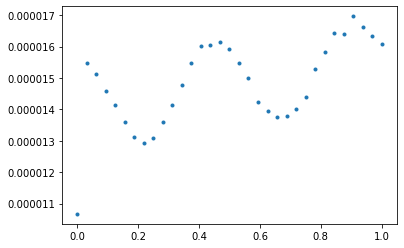

In [54]:
# Plot the energy growth measured by amplitude
plt.plot(postfix_index, [ampl.stdev**2/2 for ampl in amplitude], '.', label = 'compute from amplitude std')

# Compare with directout

# energy = readin('budgetWaterwind.dat', table_delimiter = ' ')
# plt.plot(energy.t[energy.t < 1], energy.ke[energy.t < 1]+energy.gpe[energy.t < 1], label = 'compute from directout, total')
# plt.plot(energy.t[energy.t < 1], energy.gpe[energy.t < 1], label = 'compute from directout, gpe')
# plt.plot(energy.t[energy.t < 1], energy.ke[energy.t < 1], label = 'compute from directout, ke')
# plt.legend()
# plt.title('ak = 0.05, LEVEL11')

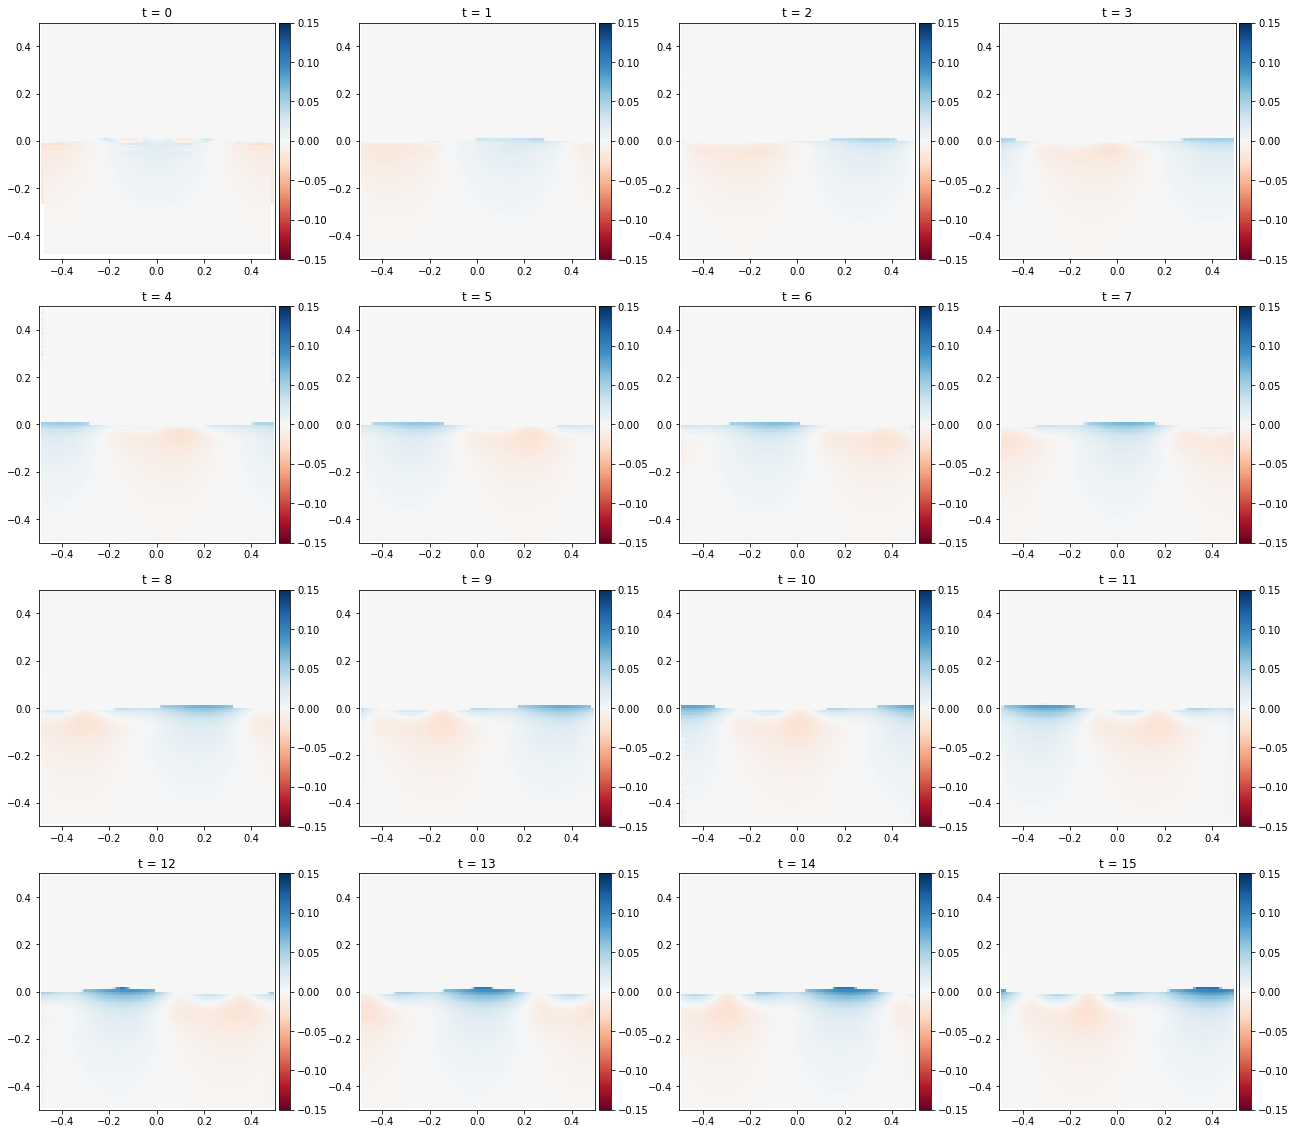

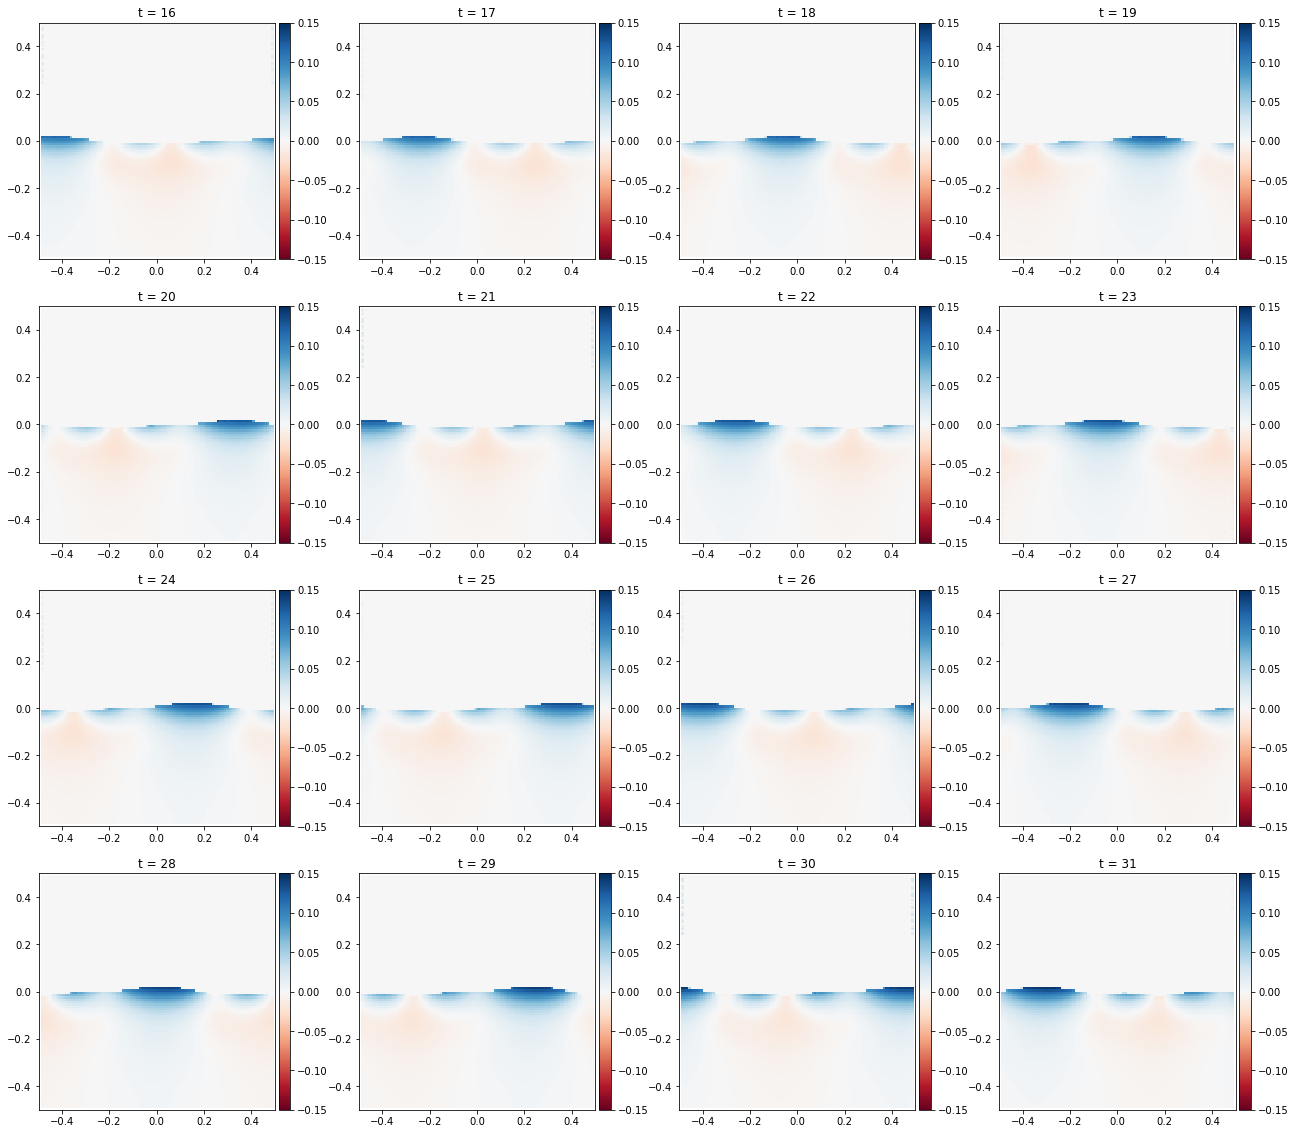

In [4]:
from visualization import contour
grid = (4, 4)
fig1, ax1 = plt.subplots(ncols=grid[1], nrows=grid[0], figsize = [22,20])
ax = ax1.flatten()
for i in range(0,16):
    t = (i)*1
    field = readin('field_direct%g' %t)
    ux_f = field.f*field['u.x']
    field['ux_f'] = ux_f
    contour(field, 'ux_f', ax[i], fieldmax=0.15, fieldmin=-0.15)
    ax[i].set_title('t = %g' %t)
fig2, ax2 = plt.subplots(ncols=grid[1], nrows=grid[0], figsize = [22,20])
ax = ax2.flatten()
for i in range(0,16):
    t = (i+16)*1
    field = readin('field_direct%g' %t)
    ux_f = field.f*field['u.x']
    field['ux_f'] = ux_f
    contour(field, 'ux_f', ax[i], fieldmax=0.15, fieldmin=-0.15)
    ax[i].set_title('t = %g' %t)

In [7]:
# To get an idea about the range of ux
field = readin('field_direct%g' %32)
ux_f = field.f*field['u.x']
field['ux_f'] = ux_f
field['ux_f'].max()

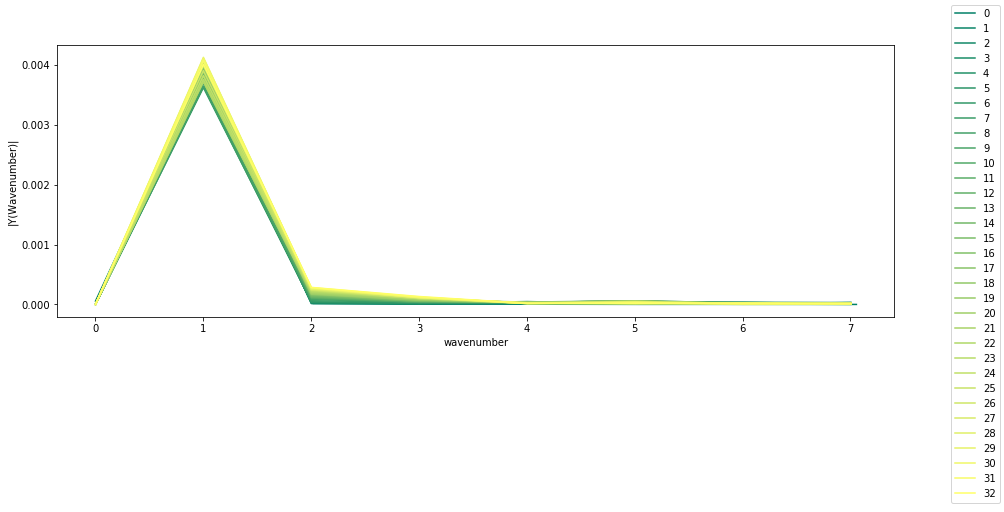

In [55]:
# Plot the power spectrum
# Need to test the FFT function and see if double the domain size changes anything
fig = plt.figure(figsize = (15, 5))
ax = fig.gca()
for i, ampl in enumerate(amplitude):
    ampl.FFT()
    ampl.plot_spectrum(ax, color_choice=plt.cm.get_cmap('summer')(color_idx[i]), label_choice = i)
fig.legend()

In [ ]:
# Cross-cases comparison is realized by a iterator of higher level
# Variables are denoted with Meta
def iter_onecase(postfix_index_set, tag_set, tag_common):

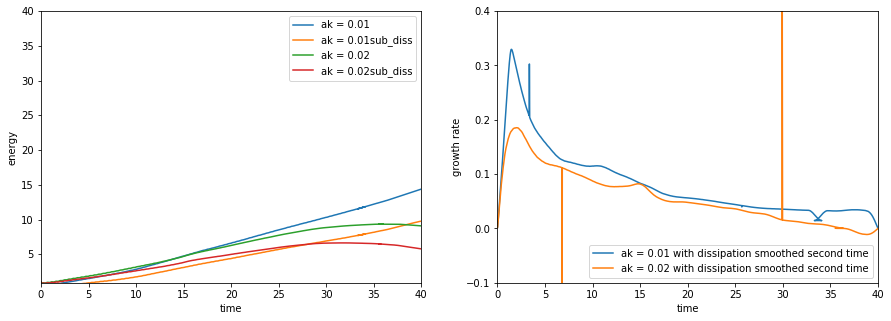

In [3]:
# Compare energy growth
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

# filename_set = ['./linear_m5B0Ustar0.5ak0.01Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.02Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.1Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.15Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
#                 './linear_m5B0Ustar0.5ak0.2Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
#                ]
filename_set = ['./linear_m5B0Ustar0.5ak0.01Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
               ]
label_set = ['ak = 0.01', 'ak = 0.02', 'ak = 0.05', 'ak = 0.1', 'ak = 0.15', 'ak = 0.2']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2, smooth = 'YES', simp = 'NO')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0.9, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

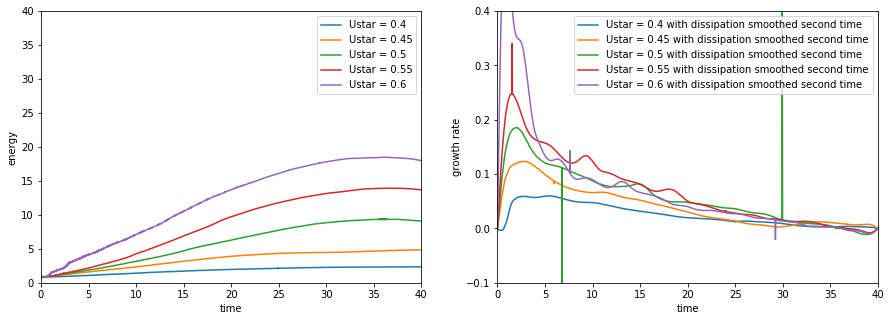

In [7]:
# Compare Ustar
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

filename_set = ['./linear_m5B0Ustar0.4ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.45ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.55ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.6ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
               ]
label_set = ['Ustar = 0.4', 'Ustar = 0.45', 'Ustar = 0.5', 'Ustar = 0.55', 'Ustar = 0.6']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

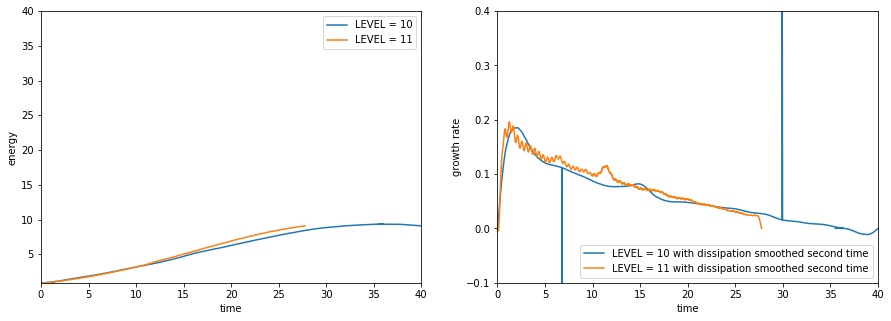

In [4]:
# Compare LEVEL
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

filename_set = ['./linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL11/budgetWaterwind.dat'
               ]
label_set = ['LEVEL = 10', 'LEVEL = 11']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0.9, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

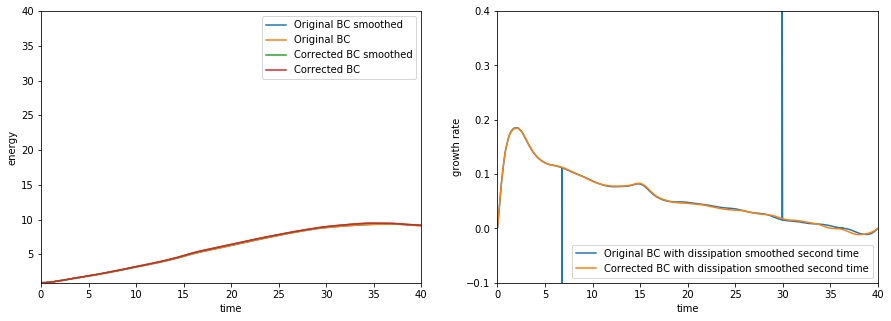

In [5]:
# Compare BC
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

filename_set = ['./linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                'linear_realchangeBC__m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat'
               ]
label_set = ['Original BC', 'Corrected BC']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0.9, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

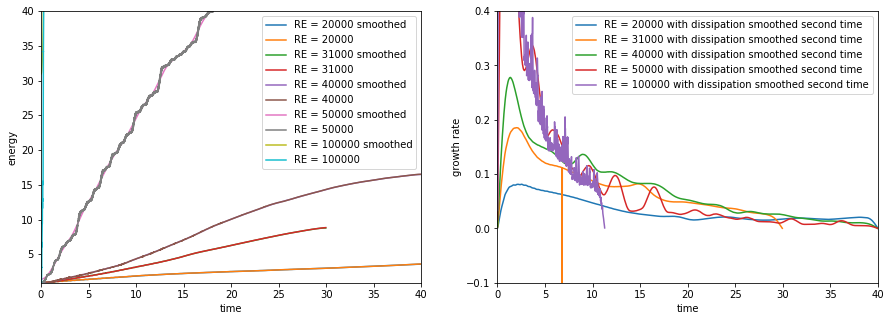

In [7]:
from energy_func import energy_comparison
# Creating 2 subplots
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# List here that cases that needs to be compared and there distinct labels

filename_set = ['./linear_m5B0Ustar0.5ak0.05Bo3.45Re20000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re40000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re50000.LEVEL10/budgetWaterwind.dat',
                './linear_m5B0Ustar0.5ak0.05Bo3.45Re100000.LEVEL10/budgetWaterwind.dat',
               ]
label_set = ['RE = 20000', 'RE = 31000', 'RE = 40000', 'RE = 50000', 'RE = 100000']
# energy = pd.read_table(filename_set[0], delimiter = ' ', error_bad_lines=False)
energy = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')
# growth_rate_set = energy_comparison(filename_set, label_set, ax1, ax2,smooth = 'YES', simp = 'YES')

ax1.legend()
ax2.legend()
# Might want to change this
ax1.set_xlim([0, 40])
ax1.set_ylim([0.9, 40])
ax2.set_xlim([0, 40])
ax2.set_ylim([-0.1, 0.4])
plt.show()

/home/jiarong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


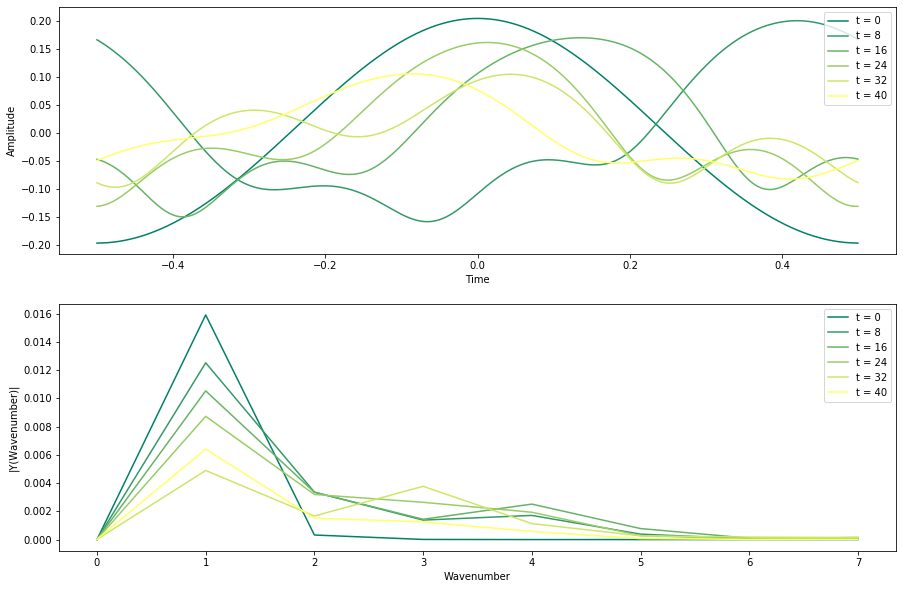

In [7]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
N = 6
M = 8
t = np.zeros(N)
color_idx = np.linspace(0, 1, N)
start = 0
for i in range(start, 41, M):
    t[(i-start)//M] = i
    filename = "./linear_m5B0Ustar0.5ak0.2Bo3.45Re31000.LEVEL10/eta%g" % t[(i-start)//M]
    exists = os.path.exists(filename)
    if not exists:
        damage = 1
        print('damaged!')
    if exists:
        interface = pd.read_table(filename, delimiter = ',')
        interface = interface.sort_values(by = ['x'])
        Fs = 2048;  # sampling rate
        Ts = 1.0/Fs; # sampling interval
        x = np.arange(-0.5,0.5,Ts) # space vector

        y = np.interp(x, interface.x, interface.pos)
        n = len(y) # length of the signal
        k = np.arange(n)
        T = n/Fs
        frq = k/T # two sides frequency range
        frq = frq[0:int(n/256)] # one side frequency range
        Y = np.fft.fft(y)/n # fft computing and normalization
        Y = Y[0:int(n/256)]
        
        ax[0].plot(x, y*2*3.14, label = 't = %.0f' %i, color=plt.cm.get_cmap('summer')(color_idx[(i-start)//M]))

#         t_smooth = t[0::20]
#         y_smooth = spline(t, y, t_smooth)
#         ax[0].plot(t_smooth, y_smooth, label = 't = %.0f' %(i/100), color=plt.cm.get_cmap('summer')(color_idx[i]))
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[0].legend()
        ax[1].plot(frq, abs(Y), label = 't = %.0f' %i, color=plt.cm.get_cmap('summer')(color_idx[(i-start)//M])) # plotting the spectrum
        ax[1].set_xlabel('Wavenumber')
        ax[1].set_ylabel('|Y(Wavenumber)|')
        ax[1].legend()
        fig.show()

In [37]:
# Read data from direct output field, interpolate onto uniform script.
# This may take some time...
field = pd.read_table('./linear_m5B0Ustar0.5ak0.05Bo3.45Re31000.LEVEL10/field_direct40', delimiter = ',')
from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
from scipy.interpolate import griddata
points = np.array([field.x, field.y])
grid_x, grid_y = np.mgrid[-0.5:0.5:100j, -0.5:0.5:100j]
grid_ux = griddata((field.x, field.y), field['u.x'], (grid_x, grid_y), method='cubic')
grid_uy = griddata((field.x, field.y), field['u.y'], (grid_x, grid_y), method='cubic')

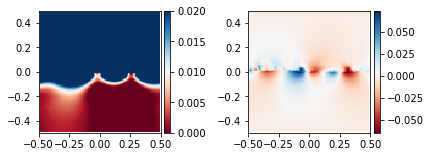

In [38]:
# Plot ux and uy of the whole domain
# Upper and lower limit can be twisted to show more clearly the details
fig, (ax1, ax2) = plt.subplots(ncols=2)
img1 = ax1.imshow(grid_ux.T, extent=(-0.5,0.5,-0.5,0.5), vmin=0, vmax=0.02, cmap='RdBu', origin='lower')
colorbar(img1)
img2 = ax2.imshow(grid_uy.T, extent=(-0.5,0.5,-0.5,0.5), cmap='RdBu', origin='lower')
colorbar(img2)
plt.tight_layout(h_pad=1)

In [4]:
# Take a closer look by cut the domain into 4 parts
A, B, C, D, E = np.split(grid_ux.T, 5)
plt.imshow(C, extent=(-0.5,0.5,0,0.25), aspect = 'auto', vmin=0, vmax=0.01, cmap='RdBu', origin='lower')
plt.colorbar()
plt.show()

NameError: name 'grid_ux' is not defined

Get the peak wavelength and frequency, compute wave speed and orbital velocity

Plot the water velocity profile and subtract the wave velocity, get the current velocity